# Start an Elasticsearch server

Haystack finds answers to queries within the documents stored in a `DocumentStore`. The current implementations of `DocumentStore` include `ElasticsearchDocumentStore`, `FAISSDocumentStore`,  `SQLDocumentStore`, and `InMemoryDocumentStore`.

**Here:** Elasticsearch is recommended as it comes preloaded with features like [full-text queries](https://www.elastic.co/guide/en/elasticsearch/reference/current/full-text-queries.html), [BM25 retrieval](https://www.elastic.co/elasticon/conf/2016/sf/improved-text-scoring-with-bm25), and [vector storage for text embeddings](https://www.elastic.co/guide/en/elasticsearch/reference/7.6/dense-vector.html).

In [2]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore # document store instance
document_store = ElasticsearchDocumentStore( # initialise the document store
    host="localhost", username="", password="", index="document" # initialise to our elasticsearch
    )

## can use the following code to check for the indices open
# import requests
# print(requests.get("http://localhost:9200/_cat/indices").text)

07/29/2021 16:56:48 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.011s]
07/29/2021 16:56:48 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.003s]
07/29/2021 16:56:48 - INFO - elasticsearch -   GET http://localhost:9200/document [status:200 request:0.003s]
07/29/2021 16:56:48 - INFO - elasticsearch -   PUT http://localhost:9200/document/_mapping [status:200 request:0.034s]
07/29/2021 16:56:48 - INFO - elasticsearch -   HEAD http://localhost:9200/label [status:200 request:0.005s]


# **STEP 1**: Get the context ready and send it into the document store to be index by elasticsearch
https://haystack.deepset.ai/docs/latest/documentstoremd

The data is stored in a excel workbook and split into News section (scraped by me) and Website section (scraped by Pang Wei).

We first read the excel file and do some simple preprocessing before splitting it into a dictionary format article by article, and finally stored into thte document store.

In [3]:
# import pandas as pd
## remove \n and +
# def clean_data(data):
#     data.replace('\n', ' ', regex=True, inplace=True)
#     data.replace(' +', ' ', regex=True, inplace=True)
#     data.replace('\t', ' ', regex=True, inplace=True) # only include cause got 1 occurance in News section
#     data = data.str.strip()
#     return data

## read from xlsx file (for >1 worksheet support)
## Since December 2020 xlrd no longer supports xlsx-Files, so need use openpyxl
# df_News = pd.read_excel('HTX knowledge base.xlsx', sheet_name='News', engine='openpyxl')
# df_Website = pd.read_excel('HTX knowledge base.xlsx', sheet_name='Website', engine='openpyxl')
# data_News = clean_data(df_News['article_content'])
# data_Website = clean_data(df_Website['article_content'])
## data_xxx.values shows all the context in a numpy.ndarray type.
# context_News = data_News.values
# context_Website = data_Website.values

## context made into a dict type for the documentstore to index
# context_json_News = [
#     {
#       'text' : paragraph,
#       'meta' : {
#           'source': 'News'}
#       } for paragraph in context_News # so each 'text' is a article.
#     ]
# print(context_json_News[:3]) # check the first 3 articles
# print(len(context_json_News)) # check the number of articles

## context made into a dict type for the documentstore to index
# context_json_Website = [
#     {
#       'text' : paragraph,
#       'meta' : {
#           'source': 'Website'}
#       } for paragraph in context_Website # so each 'text' is a article.
#     ]
# print(context_json_Website[:3]) # check the first 3 articles
# print(len(context_json_Website)) # check the number of articles

## Empty the document store
# document_store.delete_documents()

## write into the document store
# document_store.write_documents(context_json_News)
# document_store.write_documents(context_json_Website)

## check how many items in the document store of document
## ValueError: max() arg is an empty sequence if is empty
## with News + Website should have 31+15=46 articles
print(document_store.describe_documents())
## Use the below to check for embeddings when using DPR
# print(document_store.get_embedding_count())

## Check what is inside document store
# print(document_store.get_all_documents())

07/29/2021 16:56:59 - INFO - elasticsearch -   POST http://localhost:9200/document/_search?scroll=1d&size=10000 [status:200 request:0.259s]
07/29/2021 16:57:00 - INFO - elasticsearch -   POST http://localhost:9200/_search/scroll [status:200 request:0.037s]
07/29/2021 16:57:00 - INFO - elasticsearch -   DELETE http://localhost:9200/_search/scroll [status:200 request:0.015s]


{'count': 46, 'chars_mean': 3962.195652173913, 'chars_max': 18696, 'chars_min': 395, 'chars_median': 3329.5}


# **STEP 2**: Initialise the Retriever
https://haystack.deepset.ai/docs/latest/retrievermd

There are mainly 2 types of Retriever that Haystack use, Sparse and Dense Passage retriever (DPR). Testing shows better results with the BM25 retriever.

In [4]:
## BM25 method
from haystack.retriever.sparse import ElasticsearchRetriever
retriever = ElasticsearchRetriever(document_store=document_store)
## For this method, no need to update any embeddings.

In [ ]:
## DPR method (not very good from testing)
## Use embedding models from huggingface. 
from haystack.retriever.dense import DensePassageRetriever
dpr_retriever = DensePassageRetriever(document_store=document_store,
                                query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
                                passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
                                use_gpu=True,
                                )
''' Important: 
Now that after we have the DPR initialized, we need to call update_embeddings() to iterate over all
previously indexed documents and update their embedding representation. 
While this can be a time consuming operation (depending on corpus size), it only needs to be done once. 
At query time, we only need to embed the query and compare it the existing doc embeddings which is very fast.'''
# document_store.update_embeddings(dpr_retriever)
## check retriever working
# print(retriever.retrieve('Who is Clara Ho?'))
# print("-----------------------------------------------------------------------------------------------------------------------------------------------------------")
# print(dpr_retriever.retrieve('Who is Clara Ho?'))

# **STEP 3**: Initialise the Ranker
https://haystack.deepset.ai/docs/latest/rankermd


**NOTE:**
In their documentation, it is said to improve results by taking semantics into account at the cost of speed. Use when the results you get when just using retriever isn't similar to what you are asking. 
In this case of HTX website, with or ranker seems to yield no difference in results using the 10 questions I set.

**IMPORTANT**: If you plan to use the Ranker, make sure to use the pipeline that initialise the Ranker as well.

In [ ]:
## Ranker -> SentenceTransformersRanker
from haystack.ranker import SentenceTransformersRanker
ranker = SentenceTransformersRanker(model_name_or_path="cross-encoder/ms-marco-MiniLM-L-6-v2")

In [ ]:
## Ranker -> FARMRanker
from haystack.ranker import FARMRanker
ranker = FARMRanker(model_name_or_path="nboost/pt-tinybert-msmarco", 
                    num_processes=0, use_gpu=True)

# **STEP 4**: Initialise the Reader
https://haystack.deepset.ai/docs/latest/readermd

In Haystack, there are 2 main method to choose from. Either to use their FARMReader, or TransformersReader which need the user to specify which model they want from: https://huggingface.co/models?pipeline_tag=question-

From my testing, TransformersReader seems to yield better results.

In [5]:
## Tranformer method 
from haystack.reader.transformers import TransformersReader
reader = TransformersReader(
    model_name_or_path="deepset/roberta-base-squad2", use_gpu=0, max_seq_len=512
    )
## use_gpu <0, use CPU. Else GPU.
## max_seq_len default is 256, 512 seems to give better answers. 768 gives errors.

In [ ]:
## FARM method
from haystack.reader.farm import FARMReader
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True,
                    num_processes=0, max_seq_len=512)


# **STEP 5**: Initialise the Pipeline
https://haystack.deepset.ai/docs/latest/pipelinesmd

Pipelines are like a tree where one can add different components or nodes to the tree. The most basic QA pipeline would need a retriever to retrieve the relavant documents and a reader to get the short answer from the documents.
<img src="https://haystack.deepset.ai/static/7cbd0592b7e0de24ec3f5b3628ca24ae/efc66/retriever_reader.png">

In [7]:
## This is just using EQAPipeline (retriever & reader only)
from haystack.pipeline import ExtractiveQAPipeline
p = ExtractiveQAPipeline(reader=reader, retriever=retriever)

### Extractive QA with ranker
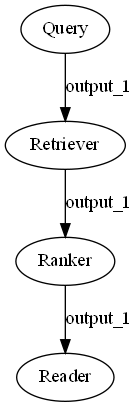

In [ ]:
## ExtractiveQA with ranker
from haystack import Pipeline
p = Pipeline()
p.add_node(component=retriever, name="Retriever", inputs=["Query"])
p.add_node(component=ranker, name="Ranker", inputs=["Retriever"])
p.add_node(component=reader,name="Reader", inputs=["Ranker"]) # Change the input to Ranker or Retriever accordingly

### Custom Pipelines
https://haystack.deepset.ai/docs/latest/pipelinesmd
<br>
1. Multiple retriever
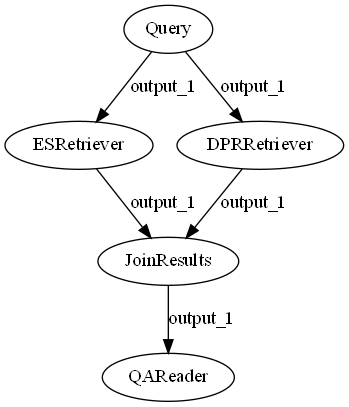
2. Multiple retriever to ranker 
<img src="mul retr then ranker.png">
3. Multiple retriever with ranker after BM25
<img src="mul retr (ranker with ESR).png">
<br>
<br>
Currently Testing shows that the 3rd option has better performance out of the 3 custom pipelines. <br>
<br>
**NOTE:** Join_mode has 2 options `concatenate` and `Merge`, though my testing doesn't show any difference between them.<br>
https://github.com/deepset-ai/haystack/blob/937247d628dd20ead0ac9e83827c5d8539fafa8f/haystack/pipeline.py

In [ ]:
## Custom pipeline 1 (Multiple retriever)
from haystack import Pipeline
from haystack.pipeline import JoinDocuments
p = Pipeline()
p.add_node(component=retriever, name="ESRetriever", inputs=["Query"])
p.add_node(component=dpr_retriever, name="DPRRetriever", inputs=["Query"])
p.add_node(component=JoinDocuments(join_mode="concatenate", top_k_join=5), name="JoinResults", inputs=["ESRetriever", "DPRRetriever"])
p.add_node(component=reader, name="QAReader", inputs=["JoinResults"])

In [ ]:
## Custom pipeline 2 (Multiple retriever to ranker)
from haystack import Pipeline
from haystack.pipeline import JoinDocuments
p = Pipeline()
p.add_node(component=retriever, name="ESRetriever", inputs=["Query"])
p.add_node(component=dpr_retriever, name="DPRRetriever", inputs=["Query"])
p.add_node(component=JoinDocuments(join_mode="concatenate", top_k_join=5), name="JoinResults", inputs=["ESRetriever", "DPRRetriever"])
p.add_node(component=ranker, name="Ranker", inputs=["JoinResults"])
p.add_node(component=reader, name="QAReader", inputs=["Ranker"])

In [ ]:
## Custom pipeline 3 (Multiple retriever with ranker after BM25)
from haystack import Pipeline
from haystack.pipeline import JoinDocuments
p = Pipeline()
p.add_node(component=retriever, name="ESRetriever", inputs=["Query"])
p.add_node(component=ranker, name="Ranker", inputs=["ESRetriever"])
p.add_node(component=dpr_retriever, name="DPRRetriever", inputs=["Query"])
p.add_node(component=JoinDocuments(join_mode="concatenate", top_k_join=5), name="JoinResults", inputs=["Ranker", "DPRRetriever"])
p.add_node(component=reader, name="QAReader", inputs=["JoinResults"])

### If you want to check what documents the retriever got, use this custom pipeline with EvalDocuments

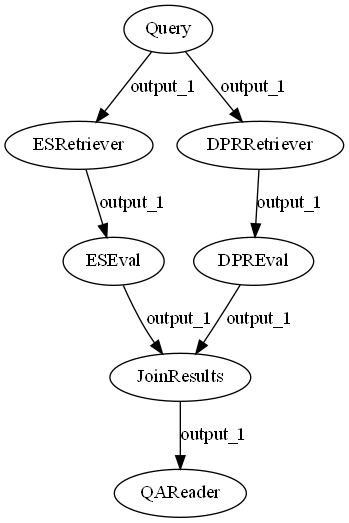
<br>
To see the documents, run Step 6 and then the logs code under **Optional** <br>
**NOTE:** Can also be used with the custom pipelines above.

In [ ]:
from haystack.eval import EvalDocuments
eval_es = EvalDocuments(debug=True)
eval_dpr = EvalDocuments(debug=True)

from haystack import MultiLabel
l = MultiLabel(question="dummy_text",
               multiple_answers=["dummy_text"],
               multiple_document_ids=["x"],
               multiple_offset_start_in_docs=[0],
               is_correct_answer=False,
               is_correct_document=False,
               origin="dummy_text")

from haystack import Pipeline
from haystack.pipeline import JoinDocuments
p = Pipeline()
p.add_node(component=retriever, name="ESRetriever", inputs=["Query"])
p.add_node(component=eval_es, name="ESEval", inputs=["ESRetriever"])
p.add_node(component=dpr_retriever, name="DPRRetriever", inputs=["Query"])
p.add_node(component=eval_dpr, name="DPREval", inputs=["DPRRetriever"])
p.add_node(component=JoinDocuments(join_mode="concatenate", top_k_join=5), name="JoinResults", inputs=["ESEval", "DPREval"])
p.add_node(component=reader, name="QAReader", inputs=["JoinResults"])

# **STEP 6**: Question-Answer

In [9]:
from haystack.utils import print_answers
from datetime import datetime 
## You can configure how many candidates the reader and retriever shall return
## The higher top_k_retriever, the better (but also the slower) your answers. 
start = datetime.now()
prediction = p.run(query="Who is Clara Ho?", top_k_retriever=5, top_k_reader=5)

## Use this to see all the details, but in a messier layout
#print_answers(prediction, details="all")

## Use this to see the 'answer', 'context' & 'probability' in a table format, but less detail
## Function credits to Clara
import pandas as pd
pd.set_option('display.max_colwidth', None)
import pprint

def print_preds_df(results):
    answers = results["answers"]
    pp = pprint.PrettyPrinter(indent=4)
    keys_to_keep = set(["answer", "context", "probability"])

    # filter the results
    filtered_answers = []
    for ans in answers:
        filtered_answers.append({k: ans[k] for k in keys_to_keep})

    df_res = pd.DataFrame({"answer":[], "context":[], "probability":[]})

    for i in filtered_answers:
        df_res.loc[len(df_res)] = i
    
    df_res.sort_values(by=['probability'], inplace = True, ascending=False)
    display(df_res)
    
print_preds_df(prediction)
print(datetime.now() - start) # print how long it takes to run the pipeline and get the answer

07/29/2021 16:59:49 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.018s]


,answer,context,probability
0,Data Scientist,"nd other Singapore security agencies. Said one associate, Clara Ho, a Data Scientist, “Being in HTX’s Data Science and AI Centre of Expertise (DSAI CoE) h",0.737899
1,Data Scientist,"nd other Singapore security agencies. Said one associate, Clara Ho, a Data Scientist, “Being in HTX’s Data Science and AI Centre of Expertise (DSAI CoE) h",0.623083
2,None,None,0.492586
3,a Data Scientist,"and other Singapore security agencies. Said one associate, Clara Ho, a Data Scientist, “Being in HTX’s Data Science and AI Centre of Expertise (DSAI CoE) h",0.314113
4,a Data Scientist,"and other Singapore security agencies. Said one associate, Clara Ho, a Data Scientist, “Being in HTX’s Data Science and AI Centre of Expertise (DSAI CoE) h",0.186492


0:00:01.019371


### Optional

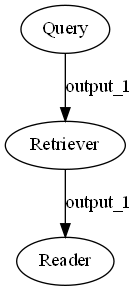

In [13]:
## draws the pipeline nodes to see where our outputs are going into.
from IPython.display import Image
p.draw(path="custom_pipe.png")
Image(filename='custom_pipe.png') 

In [ ]:
## Use this to check the what documents the retrievers got.
print(eval_es.log)

In [ ]:
print(eval_dpr.log)